# Causality Detection Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
import jdc
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline, BSpline
from tqdm import tqdm

In [2]:
def shadow_manifold(X, tau, E, L):

    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((E-1) * tau, L)} # shadow manifold
    for t in range((E-1) * tau, L):
        x_lag = [] # lagged values
        for t2 in range(0, E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*tau])            
        M[t] = x_lag
    return M

# get pairwise distances between vectors in X
def get_distances(Mx):

    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

def get_nearest_distances(t, t_steps, dists, E):

    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances

In [3]:
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):

        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = shadow_manifold(self.Y, self.tau, self.E, self.L) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = get_distances(self.My) # for distances between points in manifold    
        
    def causality(self):
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        correl = np.corrcoef(x, y)[0][1]
        
        return correl    

In [4]:
%%add_to ccm
def predict(self, t):

    eps = 0.000001 # epsilon minimum distance possible
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = get_nearest_distances(t, self.t_steps, self.dists, E)    
    
    # get weights
    u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat
  
    return X_true, X_hat

In [5]:
%%add_to ccm

def visualize_cross_mapping(self):


    f, axs = plt.subplots(1, 2, figsize=(12, 6))        
    
    for i, ax in zip((0, 1), axs): 

        X_lag, Y_lag = [], []
        for t in range(1, len(self.X)):
            X_lag.append(X[t-tau])
            Y_lag.append(Y[t-tau])    
        X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

        ax.scatter(X_t, X_lag, s=5, label='$M_x$')
        ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')


        A, B = [(self.Y, self.X), (self.X, self.Y)][i]
        cm_direction = ['Mx to My', 'My to Mx'][i]

        Ma = shadow_manifold(A, tau, E, L)
        Mb = shadow_manifold(B, tau, E, L)

        t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
        t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold


        timesteps = list(Ma.keys())
        for t in np.random.choice(timesteps, size=3, replace=False):
            Ma_t = Ma[t]
            near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A, E)

            for i in range(E+1):
                # points on Ma
                A_t = Ma[near_t_A[i]][0]
                A_lag = Ma[near_t_A[i]][1]
                ax.scatter(A_t, A_lag, c='b', marker='s')

                # corresponding points on Mb
                B_t = Mb[near_t_A[i]][0]
                B_lag = Mb[near_t_A[i]][1]
                ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                # connections
                ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

        ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
        ax.legend(prop={'size': 14})

        ax.set_xlabel('$X_t$, $Y_t$', size=15)
        ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
    plt.show()       

In [6]:
def plot_ccm_correls(X, Y, tau, E, L):

    M = shadow_manifold(Y, tau, E, L) # shadow manifold
    t_steps, dists = get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    coeff = np.round(np.corrcoef(X_My_true, X_My_pred)[0][1], 2)
    axs[0].scatter(X_My_true, X_My_pred, s=10)
    axs[0].set_xlabel('$X(t)$ (observed)', size=15)
    axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=15)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')

    # predicting Y from Mx
    coeff = np.round(np.corrcoef(Y_Mx_true, Y_Mx_pred)[0][1], 2)
    axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
    axs[1].set_xlabel('$Y(t)$ (observed)', size=15)
    axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=15)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {coeff}')
    plt.show()

In [7]:
df = pd.read_csv('ts_master.csv').drop(['Unnamed: 0'],axis =1)

In [22]:
df

,date,value,num_airbnb,ave_airbnb_price
0,2010-01,250926.2063,90.745424,118.615277
1,2010-02,250249.7925,90.912863,118.615277
2,2010-03,245685.2327,90.717496,118.615277
3,2010-04,245018.8845,90.800000,118.615277
4,2010-05,245832.8560,90.875099,118.615277
...,...,...,...,...
85,2017-02,335652.6278,93.605824,128.120915
86,2017-03,337094.3182,93.604403,142.199012
87,2017-04,338668.5369,92.694602,139.073489
88,2017-05,340450.8523,92.700284,135.348575


### Relationship between ZHVI and number of Airbnb in US Southern Region

No handles with labels found to put in legend.


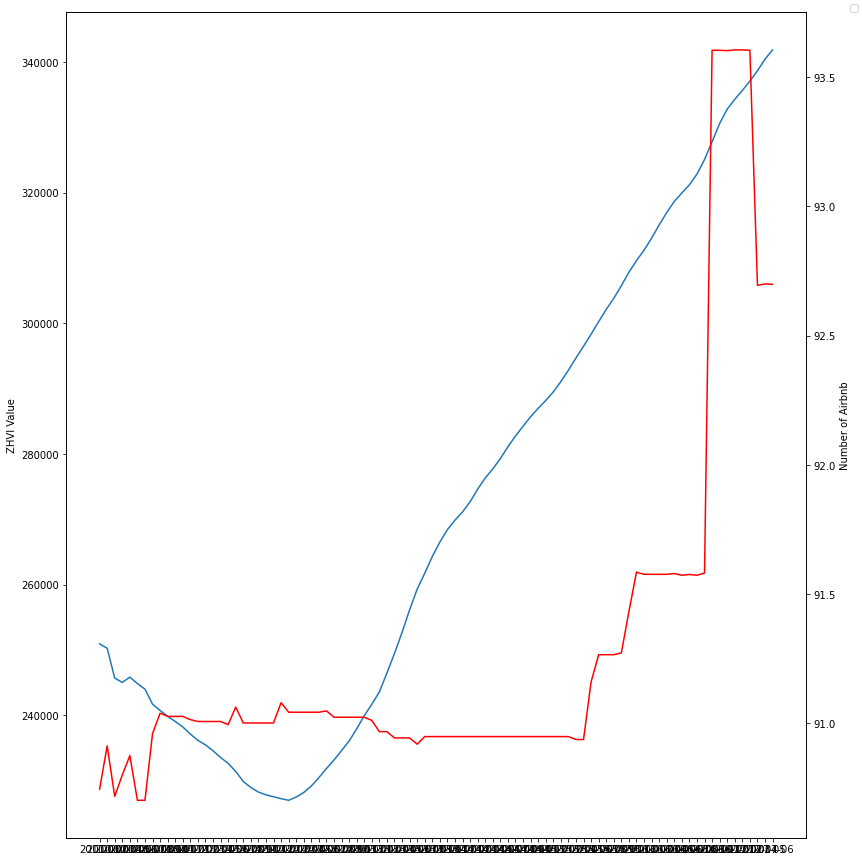

In [16]:
f, ax = plt.subplots(figsize=(12, 12))
ax.plot(df['date'], df['value'] )
ax.set_ylabel('ZHVI Value')

ax2 = ax.twinx()
ax2.plot(df['date'], df['num_airbnb'], c='r')
ax2.set_ylabel('Number of Airbnb')    

ax.figure.legend()        
plt.tight_layout()
plt.show()

Here we can see that the variables move together to an extent. This is in line with what we expected from our clustering visualization.

100%|██████████| 88/88 [00:00<00:00, 209.93it/s]


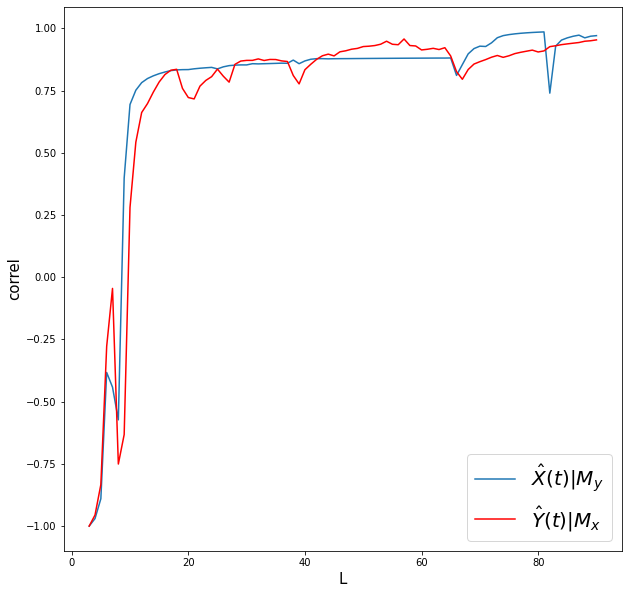

In [17]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['value']
X = df['num_airbnb']

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()) 
    Yhat_Mx.append(ccm_YX.causality())    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(10,10))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20}) 

We can see that our initial instinct was correct. There is a high degree in convergence between ZHVI values and the number of Airbnbs. This indicates that there is a high probabililty that the two variables have a causal relationship

### Relationship between ZHVI and Airbnb Prices in US Southern Region

No handles with labels found to put in legend.


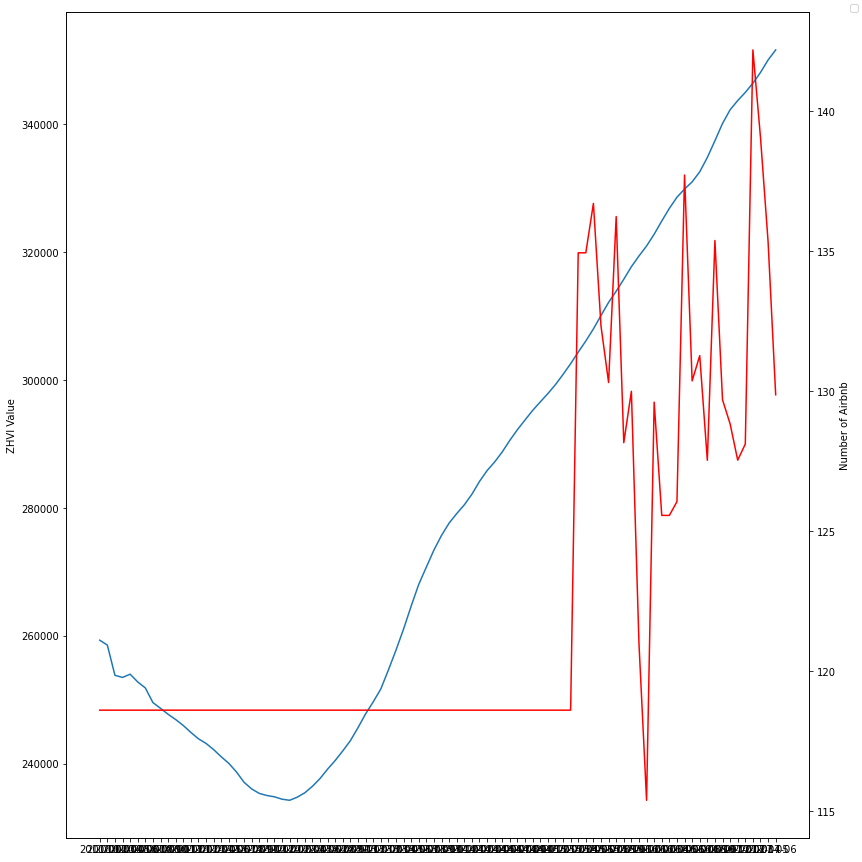

In [19]:
df2 = pd.read_csv('ts_master2.csv')
f, ax = plt.subplots(figsize=(12, 12))
ax.plot(df2['date'], df2['value'] )
ax.set_ylabel('ZHVI Value')

ax2 = ax.twinx()
ax2.plot(df2['date'], df2['ave_airbnb_price'], c='r')
ax2.set_ylabel('Number of Airbnb')    

ax.figure.legend()        
plt.tight_layout()
plt.show()

Here we can see that the variables do not move together as much as ZHVI and number of Airbnb did. While a general trend is there, Airbnb prices fluctuate more randomly than ZHVI dies

100%|██████████| 88/88 [00:00<00:00, 224.82it/s]


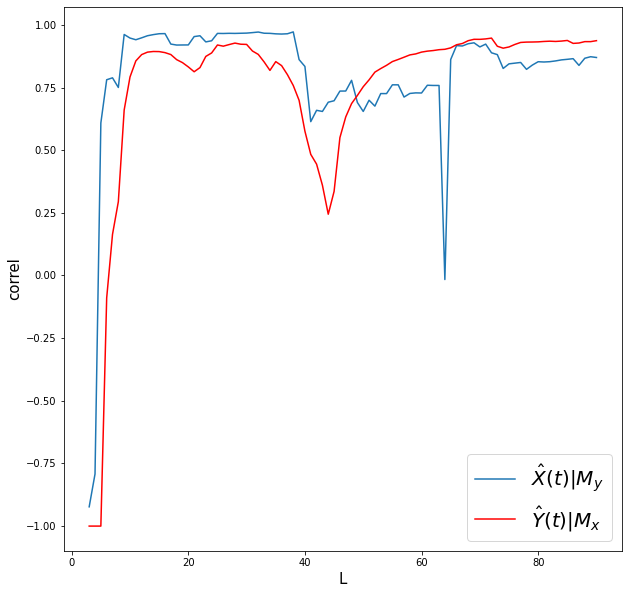

In [20]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df2['value']
X = df2['ave_airbnb_price']

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()) 
    Yhat_Mx.append(ccm_YX.causality())    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(10,10))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})    

There is a some degree in convergence between ZHVI values and the price of Airbnbs. The convergence is weaker than the previous, but it does indicate that there is a reasonable probabililty that the two variables have a causal relationship. 


### Relationship between price and number of Airbnb in US Southern Region

No handles with labels found to put in legend.


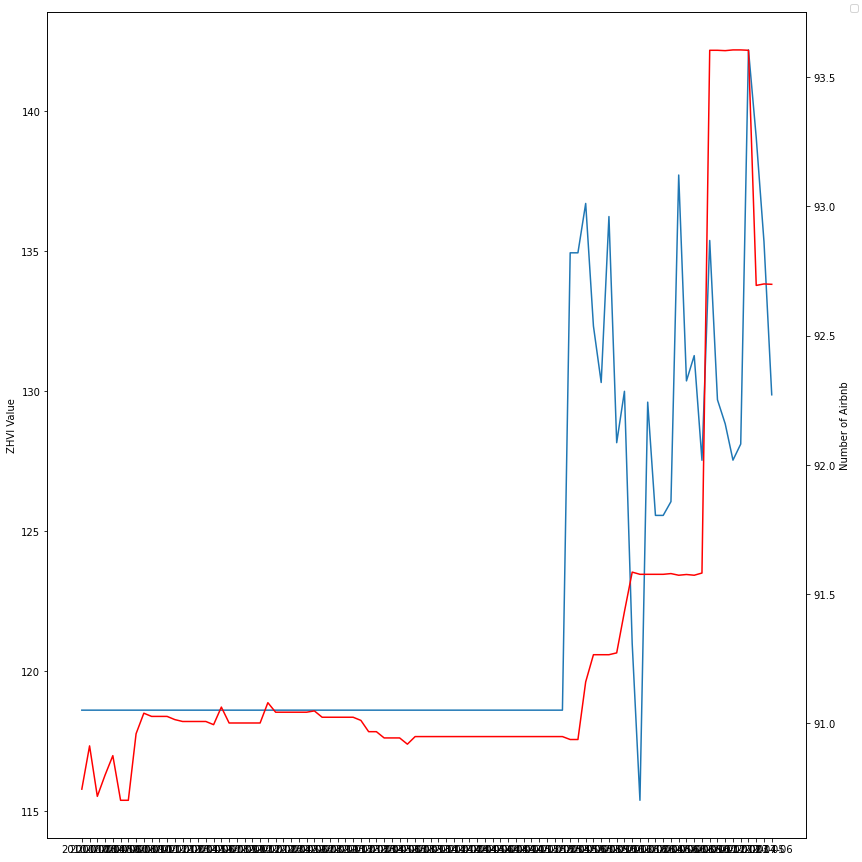

In [23]:
f, ax = plt.subplots(figsize=(12, 12))
ax.plot(df['date'], df['ave_airbnb_price'] )
ax.set_ylabel('ZHVI Value')

ax2 = ax.twinx()
ax2.plot(df['date'], df['num_airbnb'], c='r')
ax2.set_ylabel('Number of Airbnb')    

ax.figure.legend()        
plt.tight_layout()
plt.show()

Here we can see that prices and the number of Airbnbs do move together, but prices fluctuate more than the number of Airbnbs does.

  0%|          | 0/88 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 88/88 [00:00<00:00, 240.90it/s]


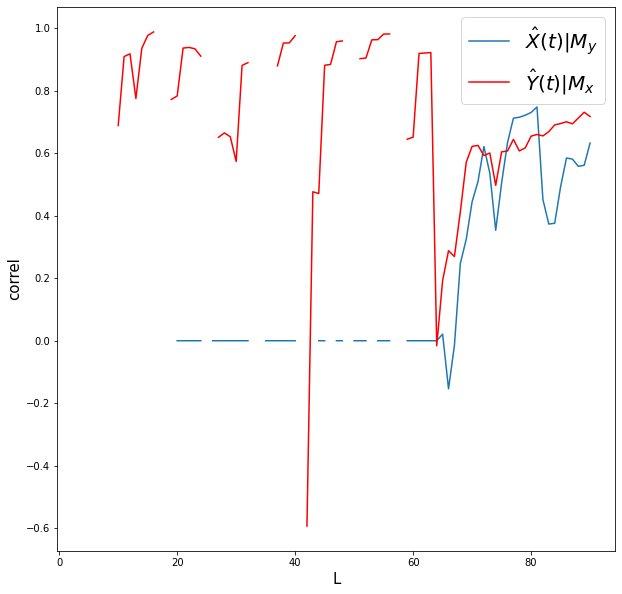

In [24]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['ave_airbnb_price']
X = df['num_airbnb']

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()) 
    Yhat_Mx.append(ccm_YX.causality())    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(10,10))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20}) 

We can see there is a weak degree of convergence between the price and number of Airbnbs. This indicates that quantity of Airbnbs in a given area is not an important feature for the price of an Airbnb. 